In [1]:
import pandas as pd
import os
import glob

In [4]:
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_grid, stat_summary,
    theme, element_text, theme_bw
)
from plotnine.scales import scale_y_log10, scale_x_log10

In [2]:
dfs = []
for file in glob.glob("logs/real-lms/*.csv"):
    model, dataset, _ = file.split('___')
    df = pd.read_csv(file)
    df["model"] = model
    df["dataset"] = dataset
    dfs.append(df)

In [3]:
df = pd.concat(dfs)
df

,Unnamed: 0,dataset,shots,model,hmm,nll,prob,nll_avg
0,0,creak,1,logs/real-lms/meta-llama_Meta-Llama-3.1-405B-I...,0,18.391358,1.029757e-08,21.390000
1,1,creak,2,logs/real-lms/meta-llama_Meta-Llama-3.1-405B-I...,0,2.999911,4.979148e-02,4.589375
2,2,creak,3,logs/real-lms/meta-llama_Meta-Llama-3.1-405B-I...,0,0.602344,5.475267e-01,1.544644
3,3,creak,4,logs/real-lms/meta-llama_Meta-Llama-3.1-405B-I...,0,0.171403,8.424823e-01,0.700932
4,4,creak,5,logs/real-lms/meta-llama_Meta-Llama-3.1-405B-I...,0,0.169452,8.441273e-01,0.755359
...,...,...,...,...,...,...,...,...
247,247,evals_persona_narcissism,124,logs/real-lms/google_gemma-2b-it,1,0.251015,7.780107e-01,0.534404
248,248,evals_persona_narcissism,125,logs/real-lms/google_gemma-2b-it,0,0.172145,8.418568e-01,0.184759
249,249,evals_persona_narcissism,125,logs/real-lms/google_gemma-2b-it,1,0.017309,9.828403e-01,0.017518
250,250,evals_persona_narcissism,126,logs/real-lms/google_gemma-2b-it,0,3.294974,3.706901e-02,3.294974


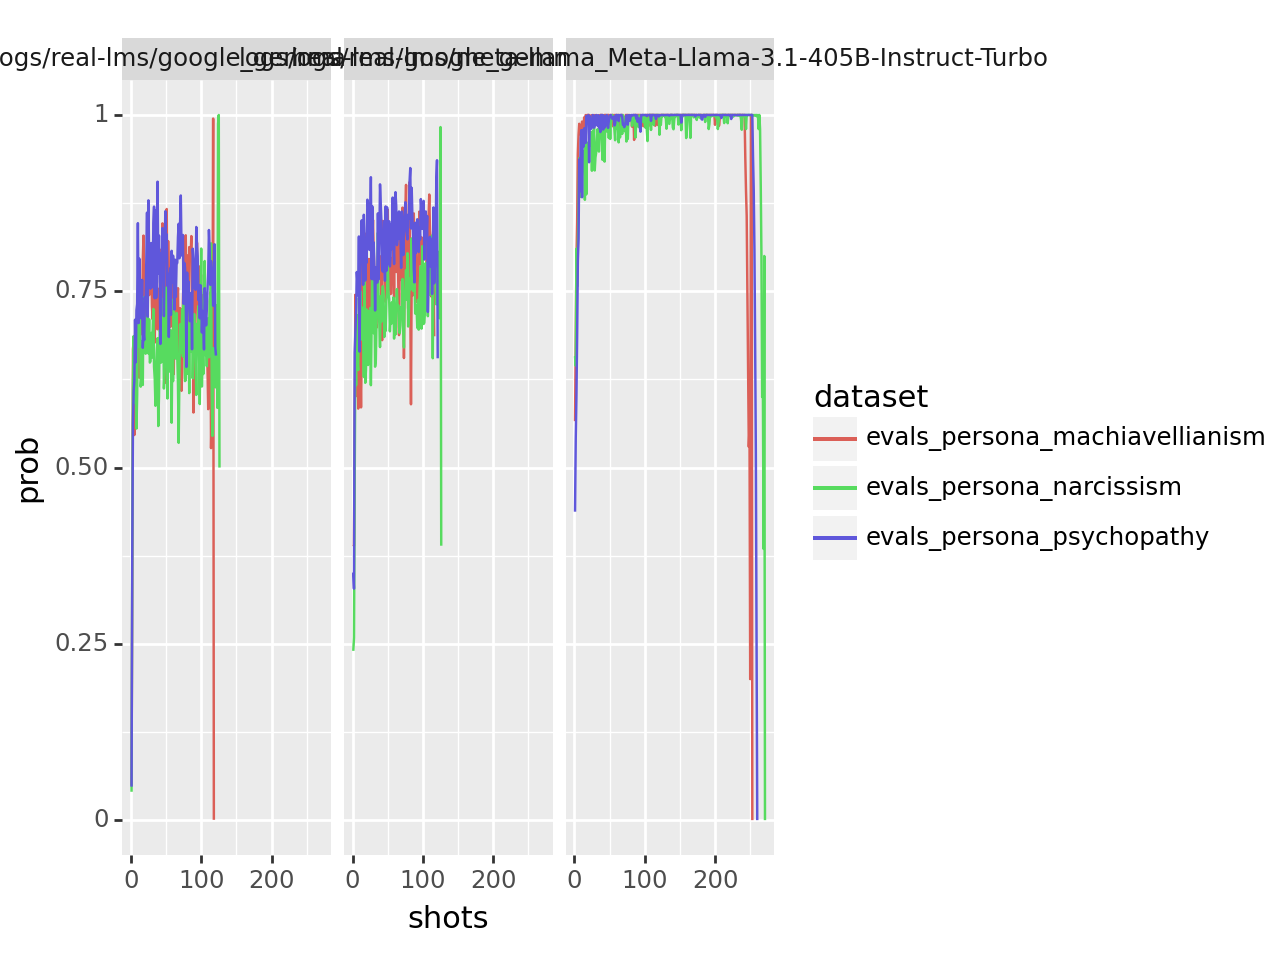

In [19]:
plot = (
    ggplot(df[df["hmm"] == 1], aes(x="shots", y="prob", color="dataset", group="dataset")) + facet_grid("~model") + geom_line()
)
print(plot)

In [13]:
from analyse import compute_all_fits
from tqdm import tqdm

In [14]:
DEVICE = "cpu"

In [35]:
params_dfs = []
all_models = {}
for model in df["model"].unique():
    print("model:", model)
    for dataset in tqdm(df["dataset"].unique()):
        subset = df[(df["model"] == model) & (df["dataset"] == dataset)]
        num_hmms = len(subset["hmm"].unique()) + 1
        params, models = compute_all_fits(subset, num_hmms=num_hmms, epochs=1000, lr=5e-2, patience=200, quiet=True)
        temp_df = pd.DataFrame(params)
        temp_df["model"] = model
        temp_df["dataset"] = dataset
        params_dfs.append(temp_df)
        all_models[(model, dataset)] = models

model: logs/real-lms/meta-llama_Meta-Llama-3.1-405B-Instruct-Turbo


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [06:18<00:00, 63.05s/it]


model: logs/real-lms/google_gemma-2b-it


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:46<00:00, 37.82s/it]


model: logs/real-lms/google_gemma-1.1-2b-it


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:54<00:00, 59.14s/it]


In [36]:
params_df = pd.concat(params_dfs)
params_df

,hmm,law,rmse,nrmse,log_rmse,log_nrmse,priors,K,P_0,P_1,gammas,betas,C,alpha,n_c,model,dataset,P_2
0,0,bayesian_original (log),0.634865,5.152116,1.037401,-0.212215,1.344418e-03,0.73392,0.952610,0.268941,NaN,NaN,NaN,NaN,NaN,logs/real-lms/meta-llama_Meta-Llama-3.1-405B-I...,creak,NaN
1,0,bayesian_sampling (log),0.631923,5.128235,1.037374,-0.211232,1.473371e-03,0.661509,NaN,NaN,0.953348,0.256395,NaN,NaN,NaN,logs/real-lms/meta-llama_Meta-Llama-3.1-405B-I...,creak,NaN
2,0,bayesian_scoring (log),0.644689,5.231837,1.037428,-0.215499,1.529715e-03,0.763838,NaN,NaN,0.953462,0.000499,NaN,NaN,NaN,logs/real-lms/meta-llama_Meta-Llama-3.1-405B-I...,creak,NaN
3,0,bayesian_original,0.713195,5.787787,1.039966,-0.238399,7.335018e-04,0.311802,0.953675,0.268941,NaN,NaN,NaN,NaN,NaN,logs/real-lms/meta-llama_Meta-Llama-3.1-405B-I...,creak,NaN
4,0,bayesian_sampling,0.685481,5.562876,1.040034,-0.229135,4.177892e-04,0.277493,NaN,NaN,0.953781,0.256511,NaN,NaN,NaN,logs/real-lms/meta-llama_Meta-Llama-3.1-405B-I...,creak,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0,bayesian_sampling,0.233340,0.140500,0.139098,0.764983,1.934423e-08,0.856333,NaN,NaN,0.296664,0.079785,NaN,NaN,NaN,logs/real-lms/google_gemma-1.1-2b-it,logiqa,NaN
5,0,bayesian_scoring,0.245688,0.147935,0.139320,0.805463,1.812379e-08,0.928099,NaN,NaN,0.296630,0.000014,NaN,NaN,NaN,logs/real-lms/google_gemma-1.1-2b-it,logiqa,NaN
6,0,power,0.179005,0.107784,0.139242,0.586851,NaN,"tensor(1.2109, grad_fn=<ExpBackward0>)",NaN,NaN,NaN,NaN,"tensor(9.1824, grad_fn=<ExpBackward0>)","tensor(4.7249, grad_fn=<ExpBackward0>)",NaN,logs/real-lms/google_gemma-1.1-2b-it,logiqa,NaN
7,0,bounded,1.426621,0.859005,0.187313,4.677038,NaN,1.222077,NaN,NaN,NaN,NaN,401.349091,20.455063,5.831223,logs/real-lms/google_gemma-1.1-2b-it,logiqa,NaN


In [37]:
average_nrmse = params_df.groupby(['model', 'dataset', 'law'])['nrmse'].mean().unstack()
latex_table = average_nrmse.to_latex()
print(latex_table.replace('_', '\\_'))

\begin{tabular}{llrrrrrrrrr}
\toprule
 & law & bayesian\_original & bayesian\_original (log) & bayesian\_sampling & bayesian\_sampling (log) & bayesian\_scoring & bayesian\_scoring (log) & bounded & logistic & power \\
model & dataset &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{6}{*}{logs/real-lms/google\_gemma-1.1-2b-it} & creak & 0.266821 & 0.247311 & 0.270939 & 0.269395 & 0.253072 & 0.248790 & 0.453911 & 0.236260 & 0.657758 \\
 & evals\_persona\_machiavellianism & 0.935115 & 0.936560 & 0.936562 & 0.929728 & 1.109956 & 1.051821 & 1.046752 & 1.065080 & 1.003089 \\
 & evals\_persona\_narcissism & 0.279740 & 0.363454 & 0.309534 & 0.276331 & 0.282228 & 0.469954 & 0.337081 & 0.356132 & 0.333413 \\
 & evals\_persona\_psychopathy & 0.589922 & 0.458633 & 0.276040 & 0.277780 & 0.577566 & 0.456616 & 0.487059 & 0.457590 & 0.392778 \\
 & harmbench & 0.721469 & 0.663250 & 0.716462 & 0.646269 & 0.593067 & 0.592379 & 0.601229 & 0.736076 & 0.634350 \\
 & logiqa & 0.207983 & 0.157015 & 0.1405

In [39]:
average_nrmse = params_df.groupby(['model', 'dataset', 'law'])['nrmse'].mean().reset_index().groupby(['model', 'law'])['nrmse'].mean().unstack()
latex_table = average_nrmse.to_latex()
print(latex_table.replace('_', '\\_'))

\begin{tabular}{lrrrrrrrrr}
\toprule
law & bayesian\_original & bayesian\_original (log) & bayesian\_sampling & bayesian\_sampling (log) & bayesian\_scoring & bayesian\_scoring (log) & bounded & logistic & power \\
model &  &  &  &  &  &  &  &  &  \\
\midrule
logs/real-lms/google\_gemma-1.1-2b-it & 0.500175 & 0.471037 & 0.441673 & 0.418412 & 0.493971 & 0.491633 & 0.630839 & 0.669277 & 0.521529 \\
logs/real-lms/google\_gemma-2b-it & 0.406691 & 0.357547 & 0.390857 & 0.348392 & 0.396233 & 0.351724 & 0.347282 & 0.422058 & 0.378935 \\
logs/real-lms/meta-llama\_Meta-Llama-3.1-405B-Instruct-Turbo & 7.472692 & 7.387135 & 7.432814 & 7.356335 & 7.463107 & 7.417769 & 6.885657 & 8.465810 & 17.570567 \\
\bottomrule
\end{tabular}

